Loading the data, check missing values and duplicates

In [2]:
import pandas as pd

# 1. Load the datasets
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

# 2. Check for missing values
print("Missing values in Fraud Data:\n", fraud_df.isnull().sum())
print("\nMissing values in IP Data:\n", ip_df.isnull().sum())

# 3. Check for duplicates
print("\nDuplicate rows in Fraud Data:", fraud_df.duplicated().sum())

# 4. Correct Data Types
# Convert signup_time and purchase_time to datetime objects
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# 5. Quick Check
print("\nData types after correction:")
print(fraud_df.dtypes[['signup_time', 'purchase_time']])
fraud_df.head()

Missing values in Fraud Data:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Missing values in IP Data:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

Duplicate rows in Fraud Data: 0

Data types after correction:
signup_time      datetime64[ns]
purchase_time    datetime64[ns]
dtype: object


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


Exploratory data analysis

C:\Users\bezaw\AppData\Local\Temp\ipykernel_1132\3865573341.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=fraud_df, palette='viridis')


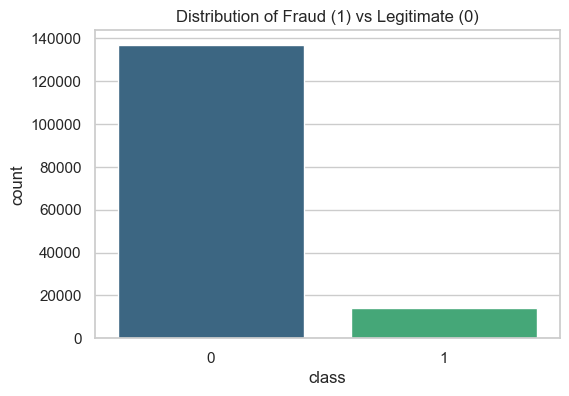

Percentage of Fraudulent Transactions: 9.36%


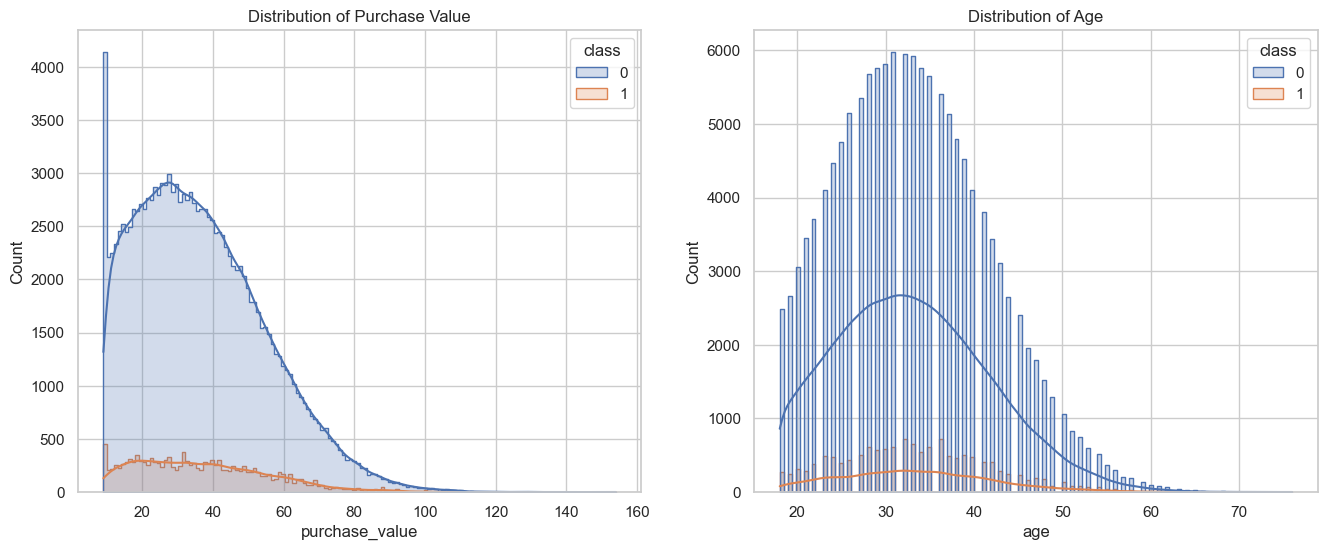

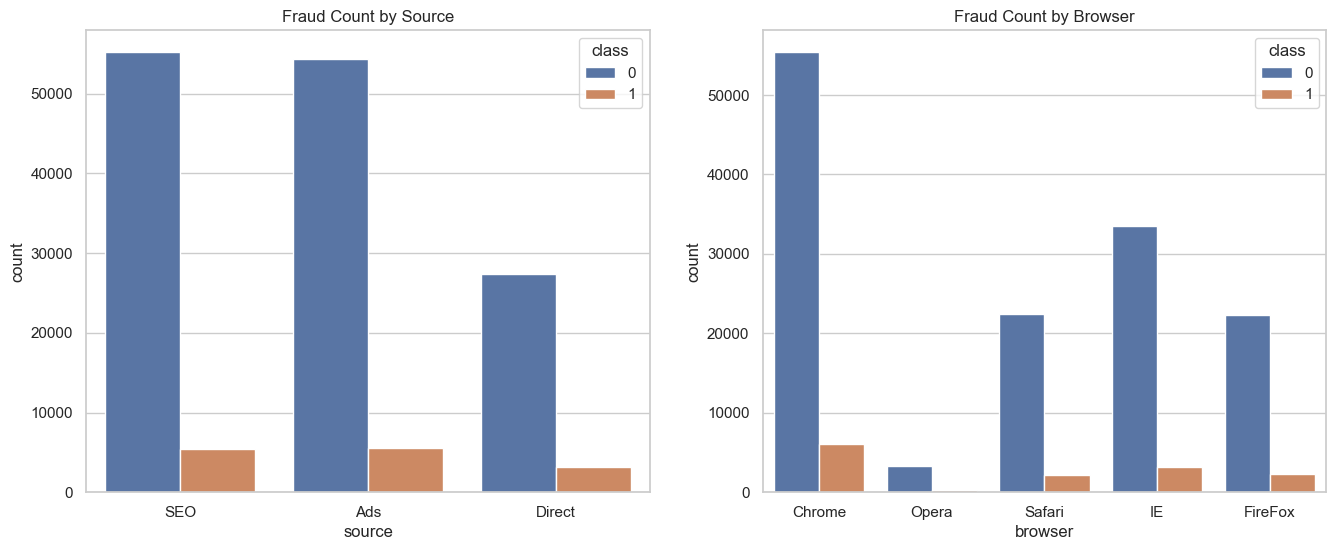

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set(style="whitegrid")

# 1. Class Distribution: How much fraud do we have?
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=fraud_df, palette='viridis')
plt.title('Distribution of Fraud (1) vs Legitimate (0)')
plt.show()

# Calculate the exact percentage
fraud_perc = fraud_df['class'].mean() * 100
print(f"Percentage of Fraudulent Transactions: {fraud_perc:.2f}%")

# 2. Numerical Distributions: Age and Purchase Value
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=fraud_df, x='purchase_value', hue='class', kde=True, element='step', ax=axes[0])
axes[0].set_title('Distribution of Purchase Value')

sns.histplot(data=fraud_df, x='age', hue='class', kde=True, element='step', ax=axes[1])
axes[1].set_title('Distribution of Age')
plt.show()

# 3. Categorical Analysis: Browser and Source
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(x='source', hue='class', data=fraud_df, ax=axes[0])
axes[0].set_title('Fraud Count by Source')

sns.countplot(x='browser', hue='class', data=fraud_df, ax=axes[1])
axes[1].set_title('Fraud Count by Browser')
plt.show()

Geological Integration : The ip_address in the data is currently a number. We need to map it to a country using the ranges provided in IpAddress_to_Country.csv

In [4]:
# 1. Ensure IP addresses are integers for precise comparison
fraud_df['ip_address'] = fraud_df['ip_address'].astype(int)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(int)

# 2. Sort both dataframes (required for efficient merging)
fraud_df = fraud_df.sort_values('ip_address')
ip_df = ip_df.sort_values('lower_bound_ip_address')

# 3. Use merge_asof for a fast range-based lookup
# This matches each IP to the nearest 'lower_bound' that is less than or equal to it
merged_df = pd.merge_asof(
    fraud_df, 
    ip_df, 
    left_on='ip_address', 
    right_on='lower_bound_ip_address'
)

# 4. Check if the IP actually falls within the upper bound
# If it's outside the range, set country to 'Unknown'
merged_df.loc[merged_df['ip_address'] > merged_df['upper_bound_ip_address'], 'country'] = 'Unknown'

# 5. Clean up extra columns and handle IPs with no match
merged_df['country'] = merged_df['country'].fillna('Unknown')
fraud_df = merged_df.drop(columns=['lower_bound_ip_address', 'upper_bound_ip_address'])

print("Geolocation Integration Complete.")
print(fraud_df[['ip_address', 'country']].head())

Geolocation Integration Complete.
   ip_address  country
0       52093  Unknown
1       93447  Unknown
2      105818  Unknown
3      117566  Unknown
4      131423  Unknown


In [5]:
# Check a sample of rows where the country is NOT Unknown
print(fraud_df[fraud_df['country'] != 'Unknown'][['ip_address', 'country']].head())

# Check how many 'Unknowns' you have in total
print(f"\nTotal Unknowns: { (fraud_df['country'] == 'Unknown').sum() }")
print(f"Total Transactions: { len(fraud_df) }")

     ip_address    country
634    16778864  Australia
635    16842045   Thailand
636    16843656      China
637    16938732      China
638    16971984   Thailand

Total Unknowns: 21966
Total Transactions: 151112


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,Unknown
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,Unknown
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,Unknown
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,Unknown
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,Unknown


EDA with Geolocation

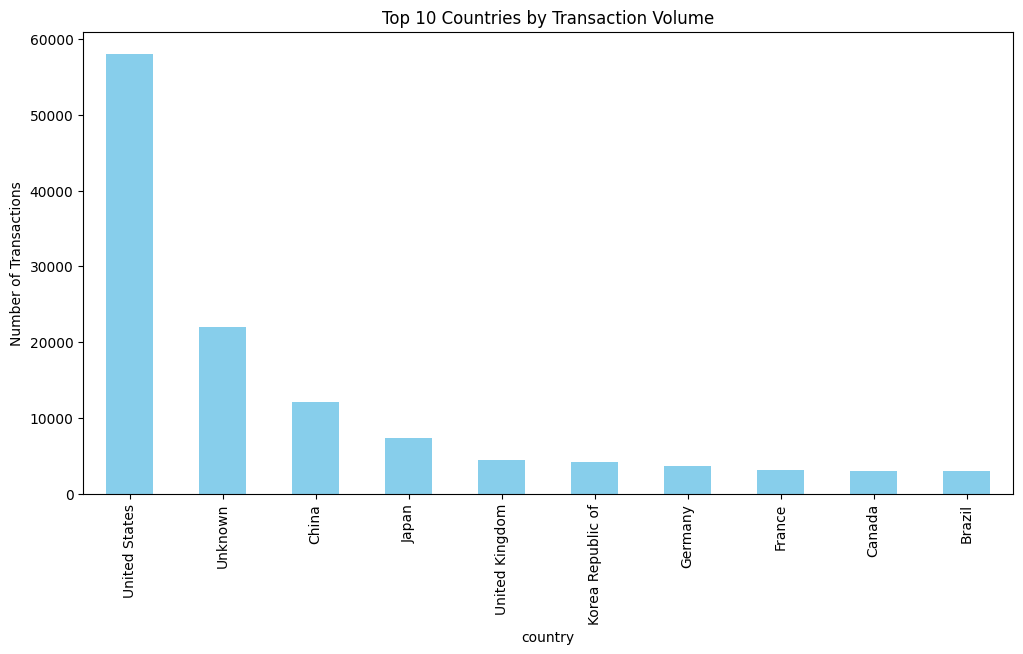

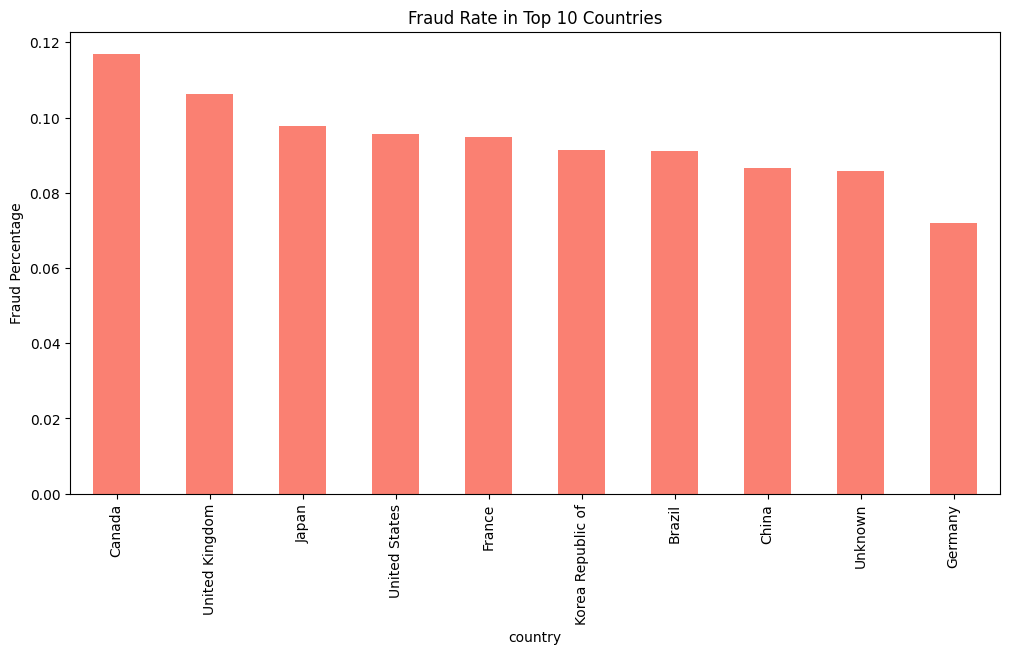

In [6]:
# 1. Top 10 countries with the most transactions
plt.figure(figsize=(12, 6))
fraud_df['country'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Transaction Volume')
plt.ylabel('Number of Transactions')
plt.show()

# 2. Fraud Rate by Country (Top 10 most frequent countries)
top_countries = fraud_df['country'].value_counts().head(10).index
fraud_rate_country = fraud_df[fraud_df['country'].isin(top_countries)].groupby('country')['class'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
fraud_rate_country.plot(kind='bar', color='salmon')
plt.title('Fraud Rate in Top 10 Countries')
plt.ylabel('Fraud Percentage')
plt.show()

--- Credit Card Class Distribution ---
Class
0    284315
1       492
Name: count, dtype: int64
Fraud Percentage: 0.1727%


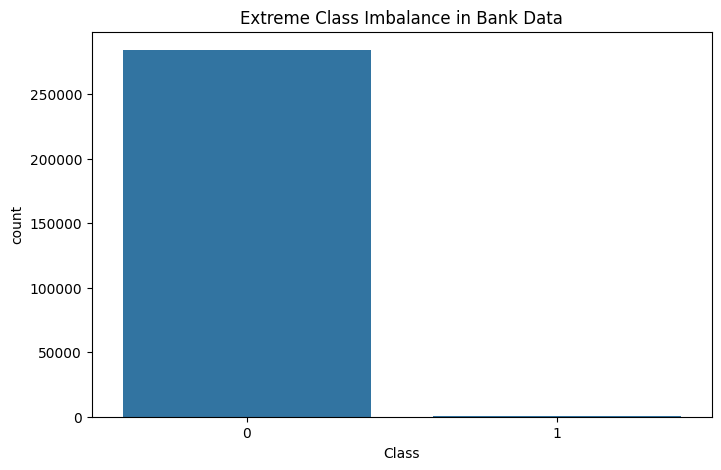

Task 1b Complete: Data Scaled and Saved.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Load the bank data
credit_df = pd.read_csv('../data/raw/creditcard.csv')

# 2. EXPLICIT CLASS IMBALANCE DOCUMENTATION
print("--- Credit Card Class Distribution ---")
print(credit_df['Class'].value_counts())
print(f"Fraud Percentage: {credit_df['Class'].mean()*100:.4f}%")

# 3. SCALING (Essential for PCA data)
# Most features (V1-V28) are already scaled. Time and Amount are NOT.
scaler = StandardScaler()
credit_df['scaled_amount'] = scaler.fit_transform(credit_df[['Amount']])
credit_df['scaled_time'] = scaler.fit_transform(credit_df[['Time']])

# Drop the old unscaled columns
credit_df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 4. VISUALIZING THE CHALLENGE
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=credit_df)
plt.title('Extreme Class Imbalance in Bank Data')
plt.show()

# 5. SAVE PROCESSED DATA
credit_df.to_csv('../data/processed/processed_creditcard.csv', index=False)
print("Task 1b Complete: Data Scaled and Saved.")

In [6]:
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

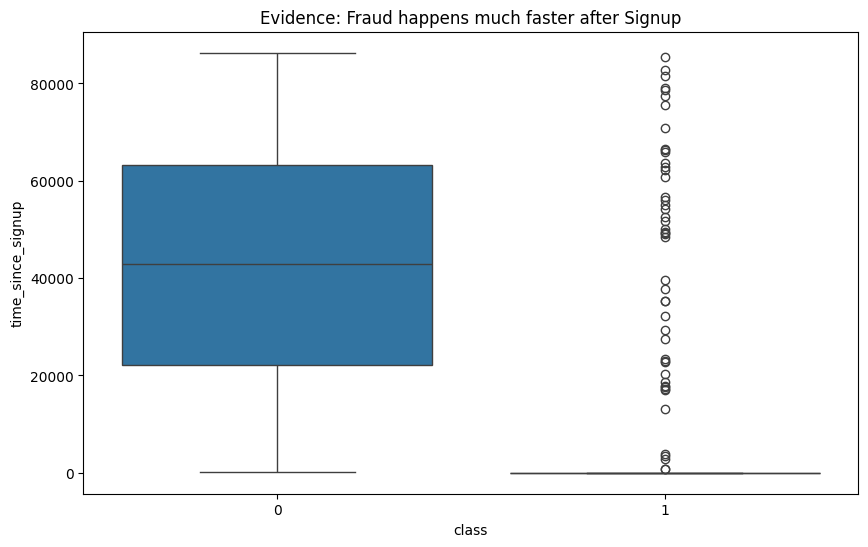

Percentage of 1-second transactions that are FRAUD: 100.00%


In [7]:
# --- This is your "Explicit Evidence" Section ---
import seaborn as sns
import matplotlib.pyplot as plt

# We use a boxplot to see if Fraudsters (1) have a lower time_since_signup than Legitimate users (0)
plt.figure(figsize=(10, 6))
# Filter for < 24 hours (86400 seconds) so the plot isn't squashed by outliers
sns.boxplot(x='class', y='time_since_signup', data=fraud_df[fraud_df['time_since_signup'] < 86400])

plt.title('Evidence: Fraud happens much faster after Signup')
plt.show()

# The statistical "Smoking Gun"
instant_fraud_rate = fraud_df[fraud_df['time_since_signup'] <= 1]['class'].mean() * 100
print(f"Percentage of 1-second transactions that are FRAUD: {instant_fraud_rate:.2f}%")

Feature Engineering

In [8]:
# 1. Time-Based Features
# Concept: "Velocity of Action"
# Fraudsters often automate signups and purchases. 
# A very short time between signup and purchase is a huge red flag.
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

# 2. Extracting Temporal Cycles
# Concept: "Dark Web Hours"
# Many fraudulent activities happen during specific hours (e.g., late at night) 
# or on specific days to avoid immediate detection.
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek

# 3. Frequency Features (The "Bot" Detector)
# Concept: "Device/IP Fingerprinting"
# One person usually has one device. If 20 different user_ids are using 
# the same device_id, it’s almost certainly a fraud farm or a bot.
fraud_df['device_id_count'] = fraud_df.groupby('device_id')['device_id'].transform('count')
fraud_df['ip_address_count'] = fraud_df.groupby('ip_address')['ip_address'].transform('count')

# Display the results
print("New Features Created Successfully!")
print(fraud_df[['user_id', 'time_since_signup', 'device_id_count', 'ip_address_count']].head())

New Features Created Successfully!
   user_id  time_since_signup  device_id_count  ip_address_count
0    62421          1763014.0                1                 1
1   173212          1084823.0                1                 1
2   242286           749320.0                1                 1
3   370003          7434634.0                1                 1
4   119824          1407619.0                1                 1


Encoding and Scaling

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Select the relevant features and drop identifiers
# We drop user_id and raw timestamps because they don't have predictive power themselves
cols_to_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address']
df_model = fraud_df.drop(columns=cols_to_drop)

# 2. Categorical Encoding
# Convert 'source', 'browser', and 'sex' into One-Hot columns
df_model = pd.get_dummies(df_model, columns=['source', 'browser', 'sex'], drop_first=True)

# Convert 'country' using Label Encoding (since there are ~180 countries)
le = LabelEncoder()
df_model['country'] = le.fit_transform(df_model['country'].astype(str))

# 3. Feature Scaling
# Scale all numerical columns to a standard range
scaler = StandardScaler()
num_cols = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 'day_of_week', 'device_id_count', 'ip_address_count']
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

# 4. Save your progress!
df_model.to_csv('../data/processed/processed_fraud_data.csv', index=False)

print("Pre-modeling preparation complete.")
print(f"Final feature count: {len(df_model.columns)}")
df_model.head()

Pre-modeling preparation complete.
Final feature count: 16


,purchase_value,age,class,country,time_since_signup,hour_of_day,day_of_week,device_id_count,ip_address_count,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,0.494721,0.331793,0,172,-1.013679,-0.220124,1.489476,-0.261514,-0.232162,True,False,False,False,False,True,True
1,-0.214781,-0.364448,0,172,-1.230613,0.792542,0.492565,-0.261514,-0.232162,False,False,False,True,False,False,False
2,-0.214781,-0.132367,0,172,-1.337931,-0.509456,-1.002803,-0.261514,-0.232162,True,False,True,False,False,False,False
3,-0.214781,0.795954,0,172,0.800513,1.371208,-0.005891,-0.261514,-0.232162,False,False,False,True,False,False,True
4,0.985915,0.563874,0,172,-1.127359,-0.654123,1.489476,-0.261514,-0.232162,False,False,False,False,False,True,True
